# 0. Imports, loading and some preprocessing


In [1]:
!pip install ucimlrepo prince plotly sklearn2pmml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
  Created wheel for sklearn2pmml: filename=sklearn2pmml-0.108.0-py3-none-any.whl size=7172101 sha256=f5eb68f2c152b0f54ef5fd49b475db94320ff7dee044abcc98f055e01a5083c8
  Stored in directory: /root/.cache/pip/wheels/c6/51/fc/986c974dc4a8d6cd9395375816678c8860d9079284c9dbe82d
Successfully built sklearn2pmml


In [2]:
from ucimlrepo import fetch_ucirepo
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import os
from time import time
import pickle
import sys
import prince
from sklearn2pmml.util import deep_sizeof
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from  lightgbm import LGBMClassifier
import plotly.express as px
import pandas as pd
from imblearn.over_sampling import SMOTE
import psutil
from scipy.stats import zscore
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_predict

In [3]:
# fetch dataset
statlog_german_credit_data = fetch_ucirepo(id=144)

X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

#convert the target class names from {1, 2} to {0, 1}
y['class'] = y['class'].astype('category')
class_mapping = {1: 0, 2: 1}
y['class'] = y['class'].map(class_mapping)


X.columns =  ['checking_account_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_account', 'employment_status', 'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence', 'property', 'age', 'other_installment_plans', 'housing', 'number_of_existing_credits', 'job', 'dependents', 'telephone', 'foreign_worker']
numerical_features = ['duration', 'credit_amount', 'installment_rate', 'present_residence', 'age', 'number_of_existing_credits', 'dependents']
categorical_features = [col for col in X.columns if col not in numerical_features]



for col in categorical_features:
    X.loc[:, col] = X[col].astype('category')

for col in numerical_features:
    X.loc[:, col] = X[col].astype('int')

X

<ipython-input-3-e2b46eb70fca>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['class'] = y['class'].astype('category')
<ipython-input-3-e2b46eb70fca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['class'] = y['class'].map(class_mapping)


,checking_account_status,duration,credit_history,purpose,credit_amount,savings_account,employment_status,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_of_existing_credits,job,dependents,telephone,foreign_worker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,4,A121,31,A143,A152,1,A172,1,A191,A201
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,4,A122,40,A143,A152,1,A174,1,A192,A201
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,4,A123,38,A143,A152,1,A173,1,A191,A201
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,4,A124,23,A143,A153,1,A173,1,A192,A201


Version of data after one-hot-encoding the categorical features and normalize the numerical features

In [4]:
def preprocess_data(X, categorical_features):
    # One-hot encode categorical features
    encoder = OneHotEncoder(sparse=False, drop='first')
    X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_features]), columns=encoder.get_feature_names_out(categorical_features))

    # Mapping one-hot encoded features back to their original categorical features
    encoded_to_cat_dict = {col: '_'.join(col.split('_')[:-1]) for col in X_encoded.columns}

    # Drop original categorical features from X
    X_processed = X.drop(columns=categorical_features)

    # Concatenate one-hot encoded features with the original dataframe
    X_processed = pd.concat([X_processed, X_encoded], axis=1)

    # Identify numerical columns (excluding one-hot encoded columns)
    numerical_cols = [col for col in X_processed.columns if col not in X_encoded.columns]

    # Normalize only the numerical features
    scaler = StandardScaler()
    X_normalized_numerical = scaler.fit_transform(X_processed[numerical_cols])

    # Convert normalized numerical array back to DataFrame
    X_normalized_numerical_df = pd.DataFrame(X_normalized_numerical, columns=numerical_cols, index=X_processed.index)

    # Concatenate the normalized numerical features with the one-hot encoded features
    X_final = pd.concat([X_normalized_numerical_df, X_encoded], axis=1)

    return X_final, encoded_to_cat_dict

# Combine the one-hot encoded features with the original dataframe
X_with_one_Hot_encoding, encoded_to_cat_dict = preprocess_data(X, categorical_features)
X_with_one_Hot_encoding

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,duration,credit_amount,installment_rate,present_residence,age,number_of_existing_credits,dependents,checking_account_status_A12,checking_account_status_A13,checking_account_status_A14,...,property_A124,other_installment_plans_A142,other_installment_plans_A143,housing_A152,housing_A153,job_A172,job_A173,job_A174,telephone_A192,foreign_worker_A202
0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.738668,-0.544162,0.024147,1.046987,-0.399832,-0.704926,-0.428290,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
996,0.754763,0.207612,0.918477,1.046987,0.391740,-0.704926,-0.428290,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
997,-0.738668,-0.874503,0.918477,1.046987,0.215835,-0.704926,-0.428290,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
998,1.999289,-0.505528,0.918477,1.046987,-1.103451,-0.704926,-0.428290,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [5]:
y['class'].value_counts()

class
0    700
1    300
Name: count, dtype: int64

I can see that the data is imbalanced

# 1. Exploring the dataset

## 1.1 basic info

In [6]:
interested_keys = ['abstract', 'tasks', 'num_instances', 'num_features', 'feature_types']

In [7]:
for key in interested_keys:
    value = statlog_german_credit_data.metadata[key]
    print(key.capitalize(), ':', value,'\n', 200*'-')

Abstract : This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix 
 --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Tasks : ['Classification'] 
 --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Num_instances : 1000 
 --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Num_features : 20 
 -----------------------------------------------------------------------------------------------------------------------------------------------------

## 1.2 Aditional info

In [8]:
for key in statlog_german_credit_data.metadata['additional_info']:
      value = statlog_german_credit_data.metadata['additional_info'][key]

      if value == None:
        continue

      print(key.capitalize(), ':', value,'\n', 200*'-')

Summary : Two datasets are provided.  the original dataset, in the form provided by Prof. Hofmann, contains categorical/symbolic attributes and is in the file "german.data".   
 
For algorithms that need numerical attributes, Strathclyde University produced the file "german.data-numeric".  This file has been edited and several indicator variables added to make it suitable for algorithms which cannot cope with categorical variables.   Several attributes that are ordered categorical (such as attribute 17) have been coded as integer.    This was the form used by StatLog.

This dataset requires use of a cost matrix (see below)

 ..... 1        2
----------------------------
  1   0        1
-----------------------
  2   5        0

(1 = Good,  2 = Bad)

The rows represent the actual classification and the columns the predicted classification.

It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1).
 
 --------------------


My insights:
*   The dataset contains attributes about individuals' financial status, employment, and personal information, utilized to classify them as good or bad credit risks.
*  It contains 13 categorical and 7 numerical features, alongside a cost matrix indicating penalties for misclassifications.

*   The dataset should ideally contain more instances labeled as 1 (Good) compared to 2 (Bad).



# 2. Data validity checking and visualization

In [9]:
def find_inconsistent_data(X, y):
    # Group by the feature columns
    grouped = X.groupby(list(X.columns))

    inconsistent_data_found = False

    # Check each group for inconsistencies in the target column
    for name, group in grouped:
        corresponding_targets = y.loc[group.index]
        if len (corresponding_targets.nunique()) > 1:
            print(f"Inconsistent data found for group: {name}")
            print(corresponding_targets)
            inconsistent_data_found = True

    if not inconsistent_data_found:
        print("No inconsistent data found.")

def check_for_null_values(X, y):
    # Check for null values in features (X)
    null_values_X = X.isnull().sum()

    # Check for null values in target (y)
    null_values_y = y.isnull().sum()


    # Display results
    if null_values_X.any() or null_values_y.any():
        print("Null values found in the dataset:")
        if null_values_X.any():
            print("In features (X):")
            print(null_values_X[null_values_X > 0])
        if null_values_y.any():
            print("In target (y):")
            print(null_values_y)
    else:
        print("No null values found in the dataset.")

def check_for_duplicates(X, y):
    # Check for duplicate rows in features (X)
    duplicates_X = X.duplicated()

    # Combine the duplicates in X with corresponding rows in y
    duplicates_combined = X[duplicates_X].join(y[duplicates_X])

    # Calculate the number of duplicate rows
    num_duplicates = duplicates_combined.shape[0]

    # Display results
    if num_duplicates > 0:
        print(f"Duplicate rows found in the dataset: {num_duplicates}")
        print(duplicates_combined)
    else:
        print("No duplicate rows found in the dataset.")

In [10]:
# Check for null values
check_for_null_values(X, y)

# Check for duplicates
check_for_duplicates(X, y)

# Find inconsistent data
find_inconsistent_data(X, y)

No null values found in the dataset.
No duplicate rows found in the dataset.
No inconsistent data found.


In [11]:
# DataFrame for Numeric Features
numeric_df = X[numerical_features]

# Calculate mean and standard deviation for each numerical feature
numeric_stats = pd.DataFrame({'Range start': numeric_df.min(),
                              'Range end':  numeric_df.max()})

numeric_stats

,Range start,Range end
duration,4,72
credit_amount,250,18424
installment_rate,1,4
present_residence,1,4
age,19,75
number_of_existing_credits,1,4
dependents,1,2


My insights:
*   No null values, duplicate rows, or inconsistent data were found in the dataset.

*   The ranges of the numerical features are within reasonable bounds, ensuring the data is representative of real-world scenarios.

# 3. Turning data into stories

## 3.1 Distribution of features in different classes

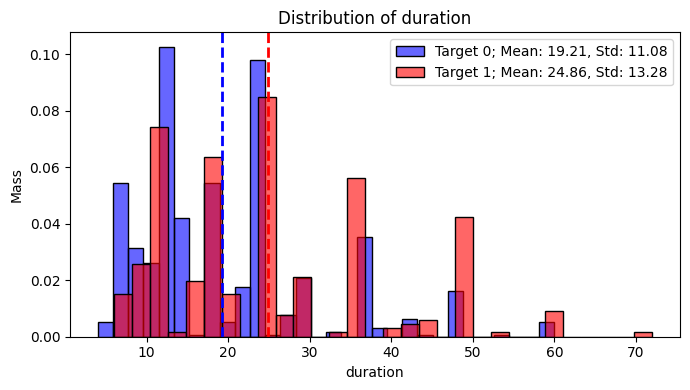

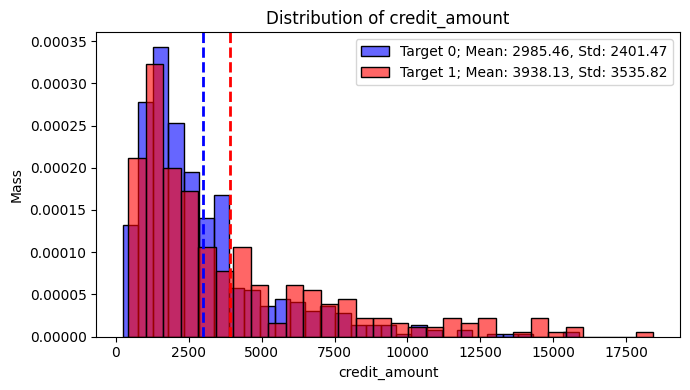

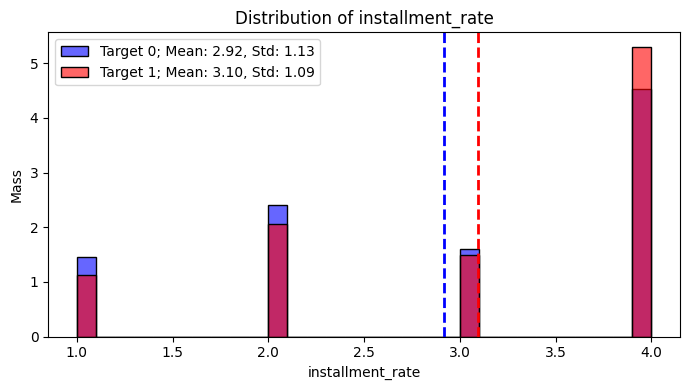

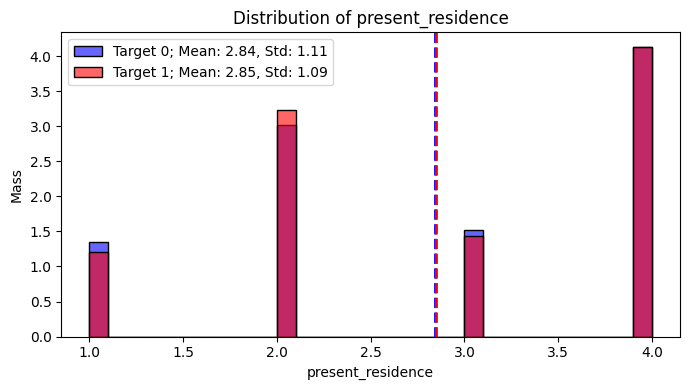

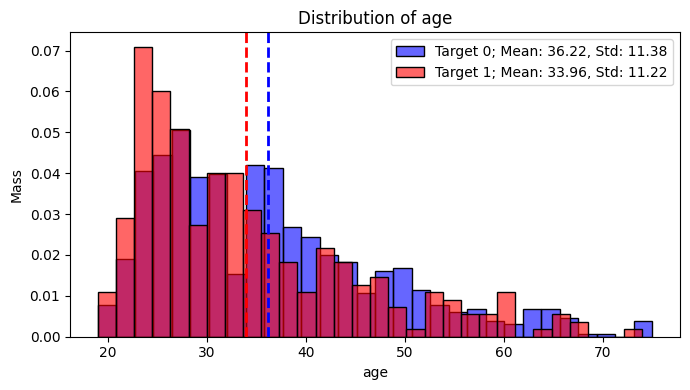

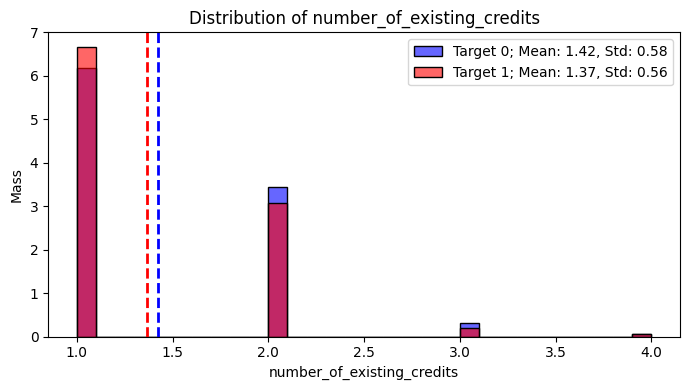

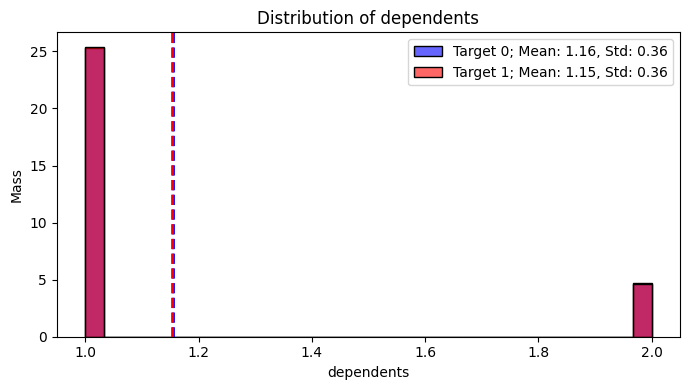

In [12]:
def plot_numerical_feature(feature_name):
    if feature_name not in numerical_features:
        raise ValueError(f"Feature '{feature_name}' is not a numerical feature.")

    # Create a DataFrame combining X and y for easier plotting
    data = pd.concat([X, y], axis=1)
    data.columns = list(X.columns) + ['target']

    # Calculate mean and standard deviation for both classes
    stats_class_1 = data[data['target'] == 0][feature_name].describe()
    stats_class_2 = data[data['target'] == 1][feature_name].describe()

    mean_1 = stats_class_1['mean']
    std_1 = stats_class_1['std']
    mean_2 = stats_class_2['mean']
    std_2 = stats_class_2['std']

    # Calculate class counts
    counts_1 = data[data['target'] == 0][feature_name].count()
    counts_2 = data[data['target'] == 1][feature_name].count()

    # Plotting
    plt.figure(figsize=(7, 4))

    # Plot histograms normalized by class counts
    sns.histplot(data=data[data['target'] == 0], x=feature_name, color='blue', label=f'Target 0; Mean: {mean_1:.2f}, Std: {std_1:.2f}', kde=False, bins=30, alpha=0.6, stat='density')
    sns.histplot(data=data[data['target'] == 1], x=feature_name, color='red', label=f'Target 1; Mean: {mean_2:.2f}, Std: {std_2:.2f}', kde=False, bins=30, alpha=0.6, stat='density')

    plt.axvline(mean_1, color='blue', linestyle='dashed', linewidth=2)
    plt.axvline(mean_2, color='red', linestyle='dashed', linewidth=2)

    # Calculate the maximum height of the normalized histogram bars
    heights_1, _ = np.histogram(data[data['target'] == 0][feature_name], bins=30, density=True)
    heights_2, _ = np.histogram(data[data['target'] == 1][feature_name], bins=30, density=True)
    max_height = max(heights_1.max(), heights_2.max())

    # Annotating mean and std above the plot
    annotation_height_1 = max_height + max_height * 0.02  # Place above the tallest bar, adjusted for spacing
    annotation_height_2 = annotation_height_1 + max_height * 0.02  # Place further above the first annotation

    plt.text(mean_1, annotation_height_1, f'', color='blue', ha='center', va='bottom')
    plt.text(mean_2, annotation_height_2, f'', ha='center', va='bottom')

    plt.title(f'Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Mass')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage: Plot histograms for all numerical features
for feature in numerical_features:
    plot_numerical_feature(feature)


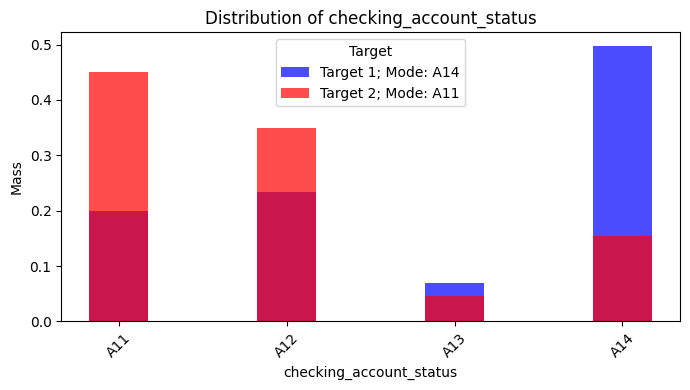

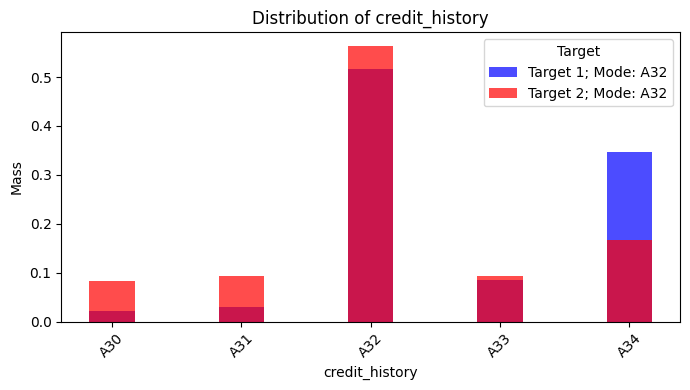

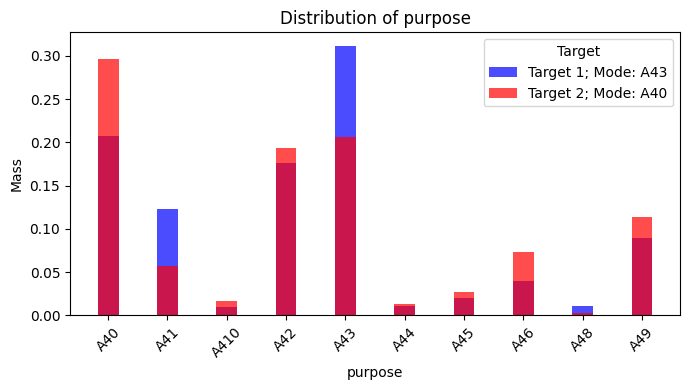

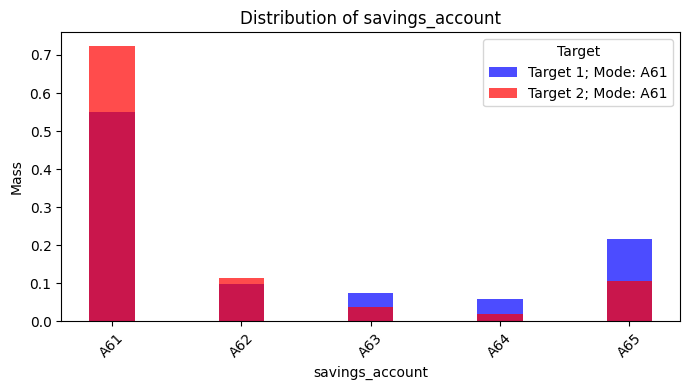

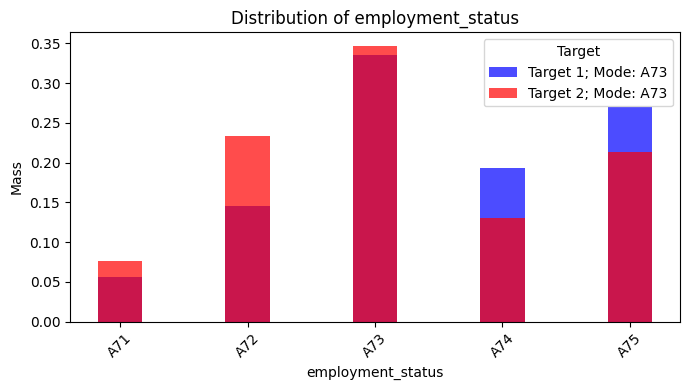

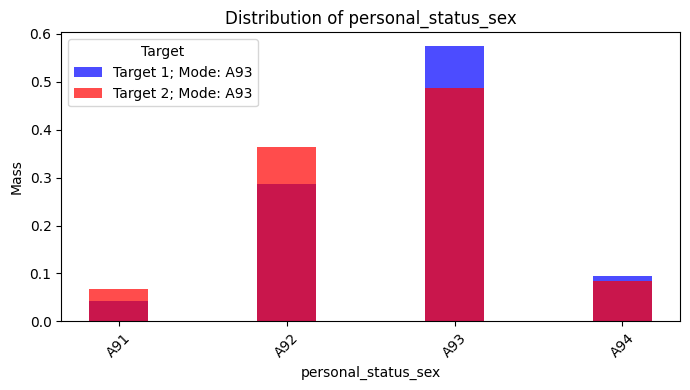

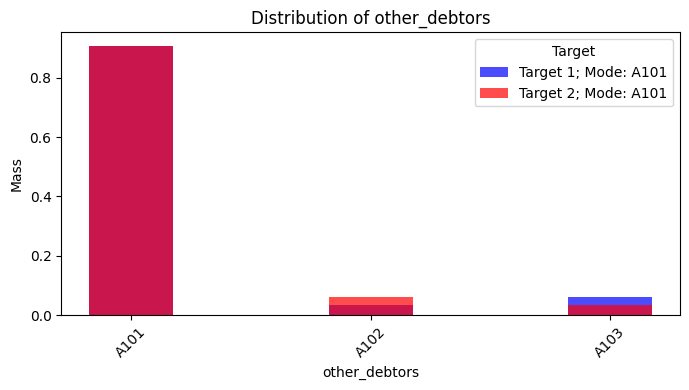

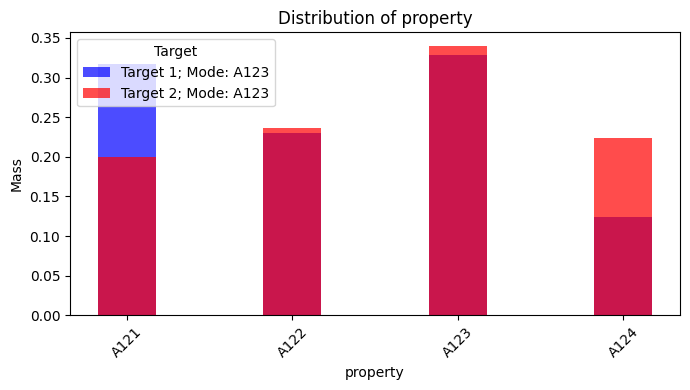

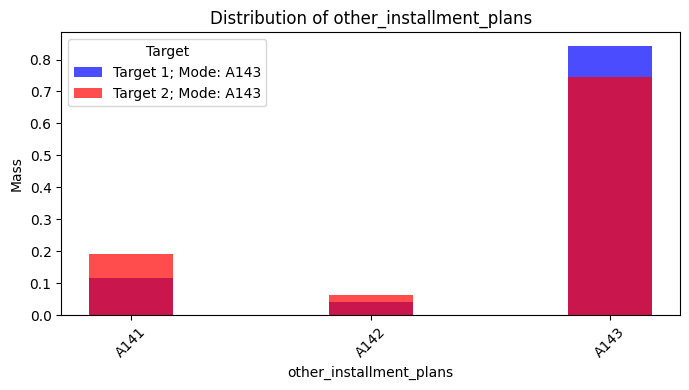

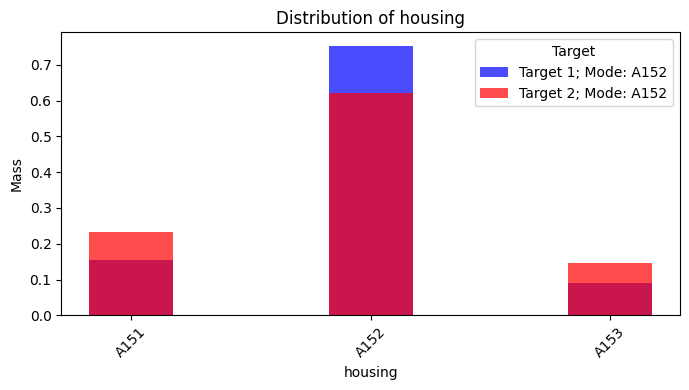

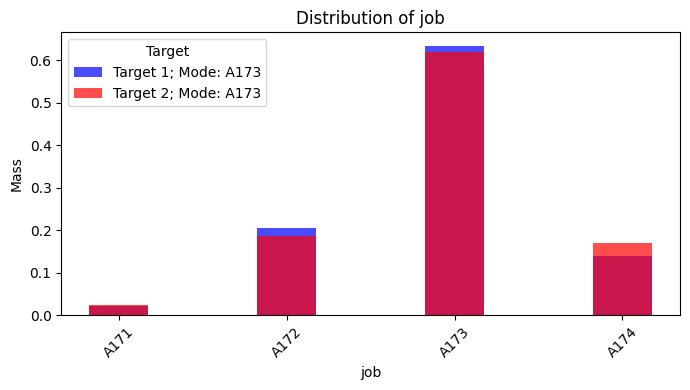

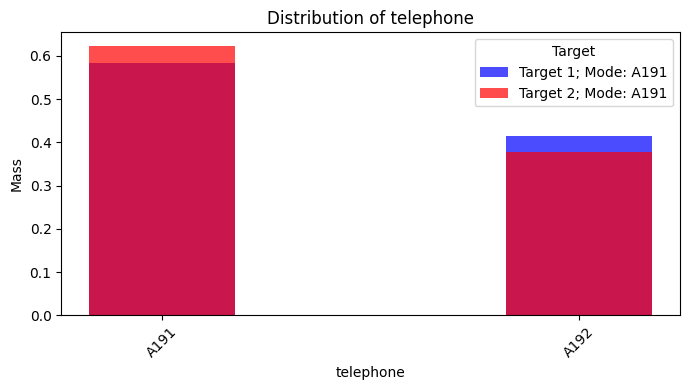

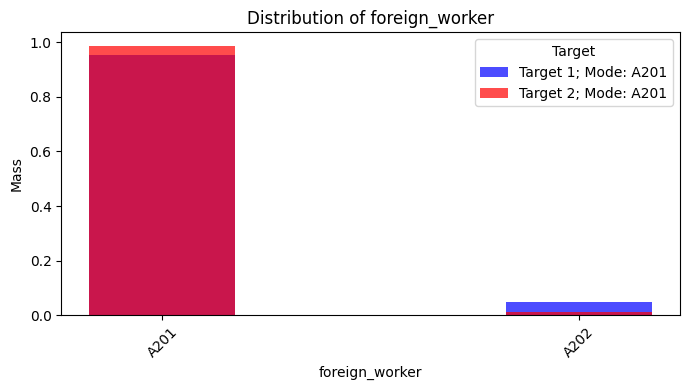

In [13]:
def plot_categorical_feature(feature_name):
    if feature_name not in categorical_features:
        raise ValueError(f"Feature '{feature_name}' is not a categorical feature.")

    # Create a DataFrame combining X and y for easier plotting
    data = pd.concat([X, y], axis=1)
    data.columns = list(X.columns) + ['target']

    # Calculate counts for each category in the feature, grouped by the target variable
    category_counts = data.groupby(['target', feature_name]).size().unstack().fillna(0)

    # Normalize counts to show proportions
    category_props = category_counts.div(category_counts.sum(axis=1), axis=0)

    # Calculate mode for each target class
    mode_target_1 = category_props.loc[0].idxmax()
    mode_target_2 = category_props.loc[1].idxmax()

    # Plotting
    fig, ax = plt.subplots(figsize=(7, 4))

    bar_width = 0.35
    index = np.arange(len(category_props.columns))

    # Plot blue bars first (in the background)
    bar1 = ax.bar(index, category_props.loc[0], bar_width, color='blue', alpha=0.7, label=f'Target 1; Mode: {mode_target_1}', zorder=1)

    # Plot red bars second (in the foreground)
    bar2 = ax.bar(index, category_props.loc[1], bar_width, color='red', alpha=0.7, label=f'Target 2; Mode: {mode_target_2}', zorder=2)

    plt.title(f'Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Mass')
    plt.xticks(index, category_props.columns, rotation=45)
    plt.legend(title='Target')
    plt.tight_layout()
    plt.show()

# Example usage: Plot bar charts for all categorical features
for feature in categorical_features:
    plot_categorical_feature(feature)

My insights:

*   Some features has almost the same probability mass function in classes 1 and 2 (Have a low correlation with the target class). This suggests these features might not be very useful on their own. And relatively have less importance on their own compared to other features
*   That is not enough to exclude  the features as while individual features may not show significant differences between classes, their combined effects with other features could be crucial in distinguishing between the two classes.


## 3.2 Relation of features and each other

### 3.2.1 Numerical features with Pearson Correlation

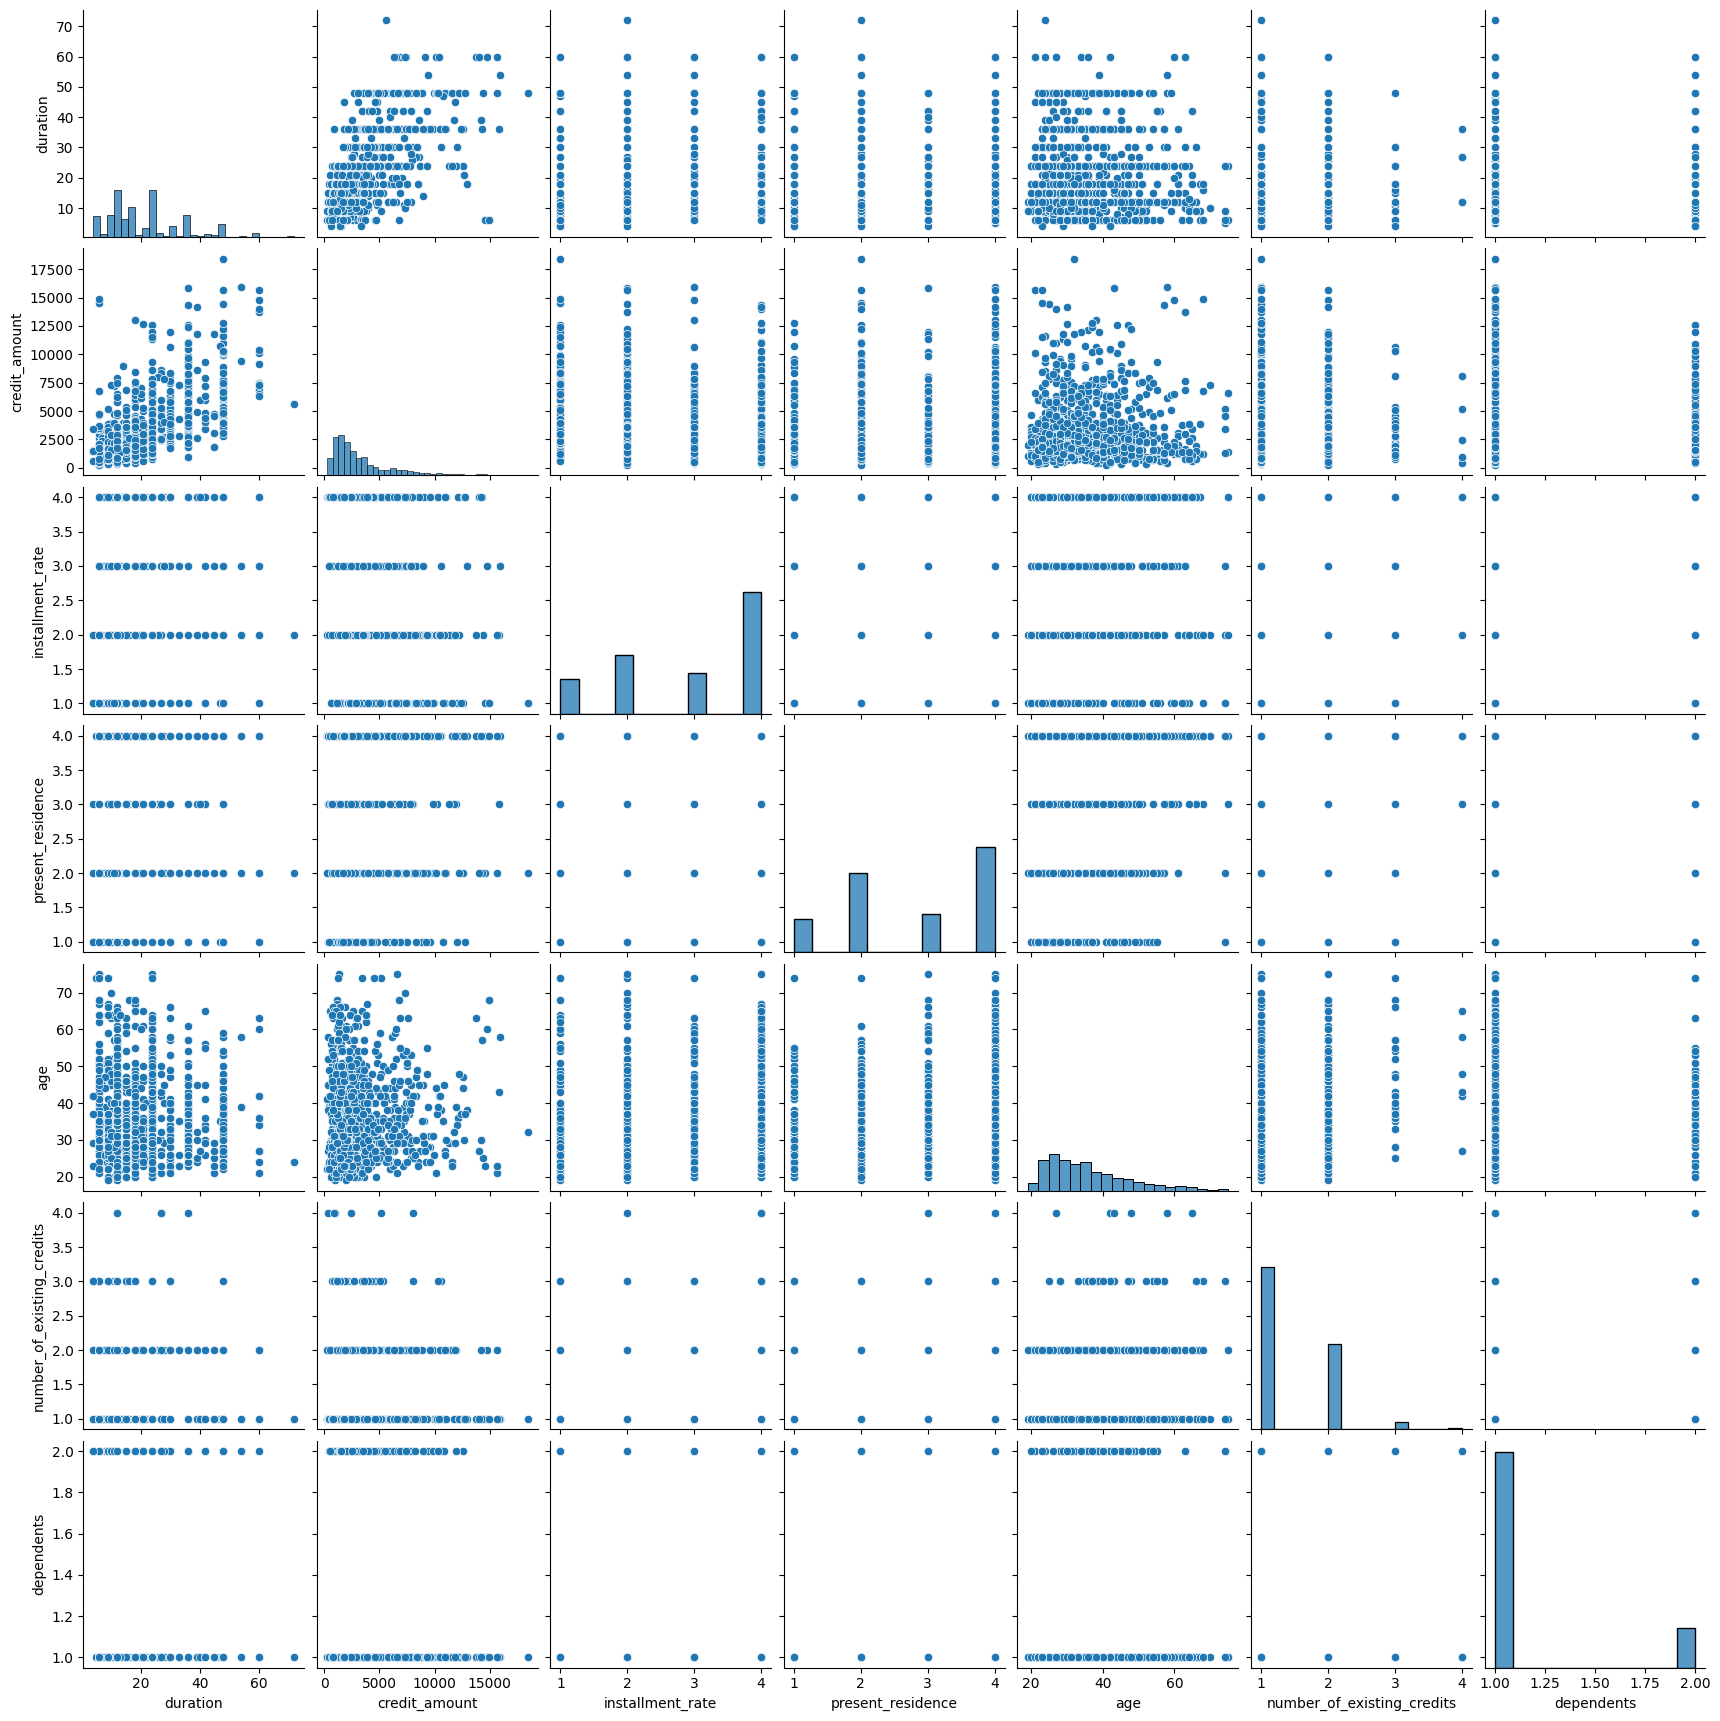

In [14]:
sns.pairplot(X)

<Axes: >

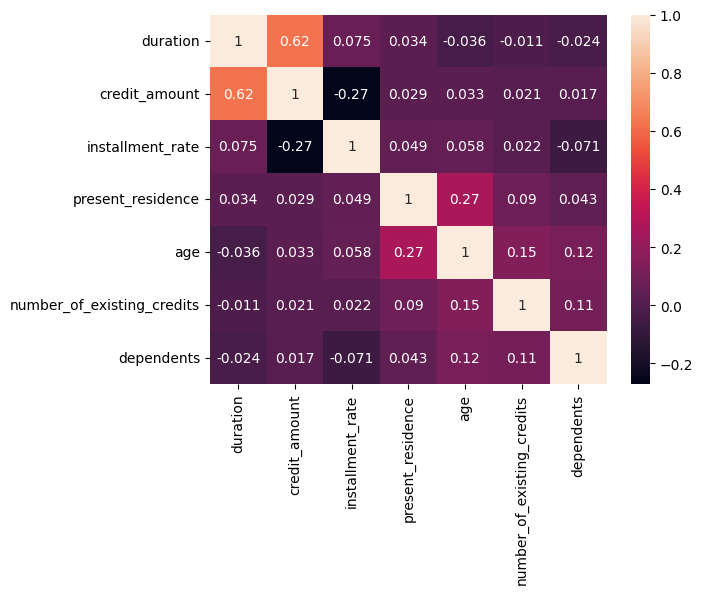

In [15]:
correlation_matrix = X[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True)

My insights:


*  Most of features pairs are uncorrelated to each other
*   We have some expection:
 *  "credit_amount" and "duration," which exhibit the strongest correlation, supported by the pairplot. This is logical as people often request longer durations for larger credits.
 * "credit_amount" and "installment_rate," which exhibit a moderate negative correlation, supported by the pairplot. This suggests that as the credit amount increases, the installment rate tends to decrease or vice versa.
 * "present_residence_since" and "age," which exhibit a moderate positive correlation, supported by the pairplot. This suggests that as the age of an individual increases, the duration of their current residence also tends to increase


### 3.2.1 Categorical features with Cramer's V

To calculate the Cramer's V correlation between two catogrical feature
$$
V = \sqrt{\frac{\chi^2/n}{\min(k-1, r-1)}}
$$


where attributes are as follows,

* $\chi^2$ is derived from Pearson's chi-squared test.
* $n$ is the grand total of observations and
*  $k$ being the number of unique categories of the first feature.
* $r$ being the number of categories of the second feature.





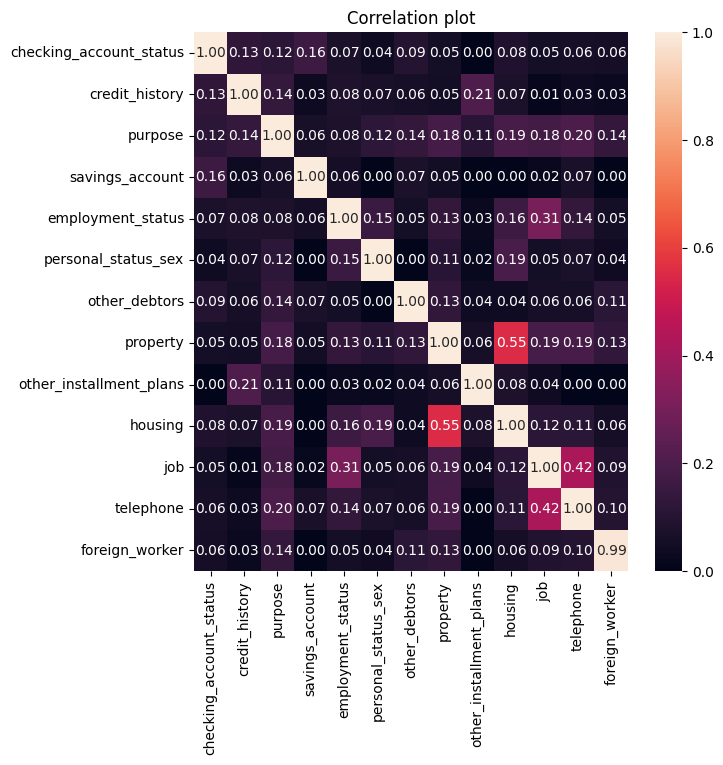

In [16]:
def cramerV(label,x):
    confusion_matrix = pd.crosstab(label, x)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r,k = confusion_matrix.shape
    phi2 = chi2/n
    phi2corr = max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r - 1) ** 2) / ( n - 1 )
    kcorr = k - ((k - 1) ** 2) / ( n - 1 )
    try:
        if min((kcorr - 1),(rcorr - 1)) == 0:
            v = 0
            print("If condition Met: ",v)
        else:
            v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
            # print("Else condition Met: ",v)
    except:
        print("inside error")
        v = 0
    return v
def plot_cramer(df):
    cramer = pd.DataFrame(index=df.columns,columns=df.columns)
    for column_of_interest in df.columns:
        try:
            temp = {}

            columns = df.columns
            for j in range(0,len(columns)):
                v = cramerV(df[column_of_interest],df[columns[j]])
                cramer.loc[column_of_interest,columns[j]] = v
                if (column_of_interest==columns[j]):
                    pass
                else:
                    temp[columns[j]] = v
            cramer.fillna(value=np.nan,inplace=True)
        except:
            print('Dropping row:',column_of_interest)
            pass
    plt.figure(figsize=(7,7))
    sns.heatmap(cramer,annot=True,fmt='.2f')

    plt.title("Correlation plot")
    plt.show()

plot_cramer(X[categorical_features])

My insights:


*  Most of features pairs are uncorrelated to each other
*   We have some expection:

 *  "housing" and "property" which exhibit the strongest correlation, supported by the plot. This is logical as people who own property are more likely to have their own housing, while renters may not necessarily own property.

 * "telephone" and "job," which exhibit a moderate correlation, supported by the plot. This is logical as people who have a steady job more likely to have a phone line registered in their name.









# 4. More feature selection

## 4.1 low variance threshold

In [17]:
THRESHOLD = 0.05

### 4.1.1 Of the numerical features




In [18]:
selector = VarianceThreshold(THRESHOLD)

# Fit the selector to your data
selector.fit(X[numerical_features])

# Get the indices of features with low variance
low_variance_indices = ~selector.get_support()

if sum(low_variance_indices) == 0:
  print("No features have low variance.")
else:
  # Get the names of features with low variance
  low_variance_features = X[numerical_features].columns[low_variance_indices]

No features have low variance.


### 4.1.1 Of the catgorical features with gini variance




Gini  variance for categorical data:

\begin{equation}
\sigma_{ii} = \frac{1}{2N^2} \sum_{a=1}^N \sum_{b=1}^N (x_{ia} - x_{ib})^2
\end{equation}

where, $\sigma_{ii}$ is the variance of the $i$-th feature, $x_{ia}$ is the value of $x_i$ for the $a$-th instance, and $N$ is the number of instances. The distance of a categorical variable between instances is defined as $x_{ia} - x_{ib} = 0$ if their values are identical, and $= 1$ otherwise.

In [19]:
def Gini_categorical_variance(df, categorical_features):
    variances = {}
    N = len(df)

    for col in categorical_features:
        xi = df[col]
        var = 0
        for a in range(N):
            for b in range(N):
                if xi[a] != xi[b]:
                    var+=1
        variances[col] = var / (2 * N**2)

    return variances

st = time()
Gini_categorical_variance(X, categorical_features)
print('execution time ',1000 * round(time() - st, 2), ' milliseconds' )

execution time  70190.0  milliseconds


The implementation above is so solw and I took the challenge to optimize it using some combinatorics tricks :)


For each column -> :
*   Store the counts of each uique value of the column in a map
*   Loop over the counts in the map and Accualmte the varaince by  $count*(N-count)$


Finally divide over $2*N^2$




In [20]:
def fast_Gini_categorical_variance(df, categorical_features):
    variances = {}
    N = len(df)

    for col in categorical_features:
        xi = df[col]
        # Get frequency of each unique value
        unique, counts = np.unique(xi, return_counts=True)
        freq = dict(zip(unique, counts))

        var = 0
        for value, count in freq.items():
            var += count * (N - count)

        variances[col] = var / (2 * N**2)

    return variances

st = time()
low_variance_features = fast_Gini_categorical_variance(X, categorical_features)
print('execution time ',1000 * round(time() - st, 2), ' milliseconds' )

execution time  10.0  milliseconds


Much faster :)

In [21]:
filtered_variances = {k: v for k, v in low_variance_features.items() if v <= THRESHOLD}
filtered_variances

{'foreign_worker': 0.035631}

My insights:

* Looking at the PMF graphs, we can see that the 'foreign_worker' variable mostly has one value. This matches our variance filtering process, showing that 'foreign_worker' doesn't change much. This confirms that our filtering method is working correctly.


## 4.2 Using matual information between X and y

The formal definition of the mutual information of two random variables X
and Y , whose joint distribution is defined by P(X, Y ) is given by

$I(X;Y) = \sum_{x \in X} \sum_{y \in Y} P(x,y) \log\left(\frac{P(x,y)}{P(x)P(y)}\right)
$

In this definition, $P(X)$ and $P(Y)$ are the marginal distributions of $X$ and $Y$.

The expression shows that mutual information measures how much the joint distribution $P(x,y)$ differs from the product of the marginal distributions $P(X) * P(Y)$


Equivalently

$I(X;Y) = D_{\text{KL}}(P(X,Y) \parallel P(X)P(Y))$



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: >

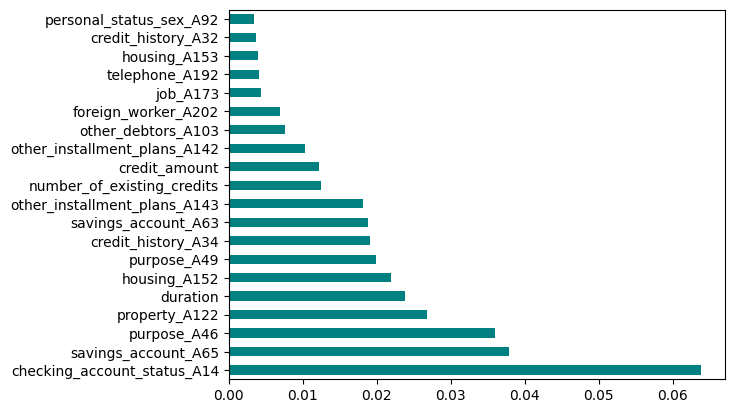

In [22]:
# Compute mutual information and set a random state for consistency
importance = mutual_info_classif(X_with_one_Hot_encoding, y, random_state=42)
feat_importance = pd.Series(importance, X_with_one_Hot_encoding.columns)
feat_importance.sort_values(ascending=False)[:20].plot(kind='barh', color='teal')

My insights:

* Returning to the PMF graphs, we can clearly observe distinct distributions for the top three crucial features: 'checking_account_status_A14', 'saving_account_A65', and 'purpose_A64'.

* These differences in distribution patterns further validate the accuracy of our identified top features.

## 4.3 Choosing the new best subsets of features

In [23]:
# Replace one-hot encoded feature names with original feature names in the importance series
feat_importance_mapped = feat_importance.rename(index=encoded_to_cat_dict)

# Group by original feature names and sum their importance
feat_importance_grouped = feat_importance_mapped.groupby(level=0).sum()

# Print the top 13 features
top_features = list(feat_importance_grouped.sort_values(ascending=False).head(13).keys())
top_features

['checking_account_status',
 'savings_account',
 'purpose',
 'property',
 'other_installment_plans',
 'housing',
 'duration',
 'credit_history',
 'number_of_existing_credits',
 'credit_amount',
 'other_debtors',
 'foreign_worker',
 'job']

*   I will remove the feature 'credit_amout' as it higly corelates to 'duation' as I have mentioned earlier
*   The same goes for 'housing' as it higly corelates to 'property'



In [24]:
if 'credit_amount' in top_features:
  top_features.remove('credit_amount')
if 'housing' in top_features:
  top_features.remove('housing')

print('We have now ',len(top_features  ), ' features')
small_X_data = X.copy()

small_X_data
#filter the small_X_data by the top features
small_X_data = small_X_data[top_features]
small_X_data

We have now  11  features


,checking_account_status,savings_account,purpose,property,other_installment_plans,duration,credit_history,number_of_existing_credits,other_debtors,foreign_worker,job
0,A11,A65,A43,A121,A143,6,A34,2,A101,A201,A173
1,A12,A61,A43,A121,A143,48,A32,1,A101,A201,A173
2,A14,A61,A46,A121,A143,12,A34,1,A101,A201,A172
3,A11,A61,A42,A122,A143,42,A32,1,A103,A201,A173
4,A11,A61,A40,A124,A143,24,A33,2,A101,A201,A173
...,...,...,...,...,...,...,...,...,...,...,...
995,A14,A61,A42,A121,A143,12,A32,1,A101,A201,A172
996,A11,A61,A41,A122,A143,30,A32,1,A101,A201,A174
997,A14,A61,A43,A123,A143,12,A32,1,A101,A201,A173
998,A11,A61,A43,A124,A143,45,A32,1,A101,A201,A173


In [25]:
# Identify categorical features that exist in top_features
categorical_features_in_top = [feature for feature in top_features if feature in categorical_features]

# Preprocess small_X_data using the identified categorical features in top_features
small_X_with_one_Hot_encoding,  _ = preprocess_data(small_X_data, categorical_features_in_top)
small_X_with_one_Hot_encoding

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,duration,number_of_existing_credits,checking_account_status_A12,checking_account_status_A13,checking_account_status_A14,savings_account_A62,savings_account_A63,savings_account_A64,savings_account_A65,purpose_A41,...,credit_history_A31,credit_history_A32,credit_history_A33,credit_history_A34,other_debtors_A102,other_debtors_A103,foreign_worker_A202,job_A172,job_A173,job_A174
0,-1.236478,1.027079,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.248194,-0.704926,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.738668,-0.704926,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.750384,-0.704926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.256953,1.027079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.738668,-0.704926,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
996,0.754763,-0.704926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
997,-0.738668,-0.704926,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
998,1.999289,-0.704926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 4.4 Making A new synthesized features from the top components

Necessary step to make it work with 'prince' implementation of FAMD

In [26]:
X_with_floats = X.copy()


for col in numerical_features:
    X_with_floats.loc[:, col] = X_with_floats[col].astype('float') + 0.0000000001

print(X_with_floats.dtypes)

checking_account_status        object
duration                      float64
credit_history                 object
purpose                        object
credit_amount                 float64
savings_account                object
employment_status              object
installment_rate              float64
personal_status_sex            object
other_debtors                  object
present_residence             float64
property                       object
age                           float64
other_installment_plans        object
housing                        object
number_of_existing_credits    float64
job                            object
dependents                    float64
telephone                      object
foreign_worker                 object
dtype: object


In [27]:
famd = prince.FAMD(
    n_components=10,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)
famd = famd.fit(X_with_floats)

In [28]:
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,16.923,6.19%,6.19%
1,12.010,4.39%,10.58%
2,10.681,3.91%,14.48%
3,10.186,3.72%,18.21%
4,9.656,3.53%,21.74%
5,8.936,3.27%,25.01%
6,8.570,3.13%,28.14%
7,8.313,3.04%,31.18%
8,8.237,3.01%,34.19%


My insights:


*   Looking back at the correlation analysis, it was clear that the majority of features show weak correlations. Therefore, the principal components created from these features have low variance and might not capture alot of important patterns in the data.

  

In [29]:
new_synthesized_X = famd.row_coordinates(X_with_floats)

In [30]:
new_synthesized_X

component,0,1,2,3,4,5,6,7,8,9
0,1.025814,-3.862550,-4.466198,-0.141303,2.181636,-1.786624,1.256516,-0.628393,0.706083,0.632073
1,-4.126975,0.644449,0.664512,0.370581,-0.078626,3.808177,1.515510,-2.685045,1.983102,0.388596
2,-1.427149,-1.927256,-5.176028,1.739299,0.164527,-0.199601,-2.832540,2.553733,-0.736097,1.519370
3,0.321174,4.331178,-3.652163,0.172979,-4.935367,-3.859580,3.555164,-2.309821,-1.260064,4.996321
4,5.781389,2.678821,-4.177189,2.518972,-3.911686,1.637008,-3.882599,-3.072569,-0.400383,2.651158
...,...,...,...,...,...,...,...,...,...,...
995,-4.729571,0.890750,-1.088752,-1.201848,-0.073893,-1.174476,-0.385930,1.076308,0.032930,1.160774
996,2.864171,0.236385,3.425487,-3.506002,-0.406382,-4.660378,0.099222,-4.804309,0.631414,3.063418
997,-0.874705,-4.083706,-1.842243,-0.963275,0.308868,0.898892,1.865919,-1.214036,2.739396,-0.380574
998,5.506618,2.108916,-3.909878,-0.645282,-3.871063,2.745700,1.537874,-4.243207,2.666076,2.533815


# 5.0 Training

## 5.1 The baseline

Important Note:

While tree ensemble-based algorithms typically perform well with unnormalized and non-encoded data, I will be using the normalized and encoded version from now on. This choice is made to ensure consistency and compatibility with the rest of the models

In [31]:
models = []
models.append(('LGR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGBM', XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)))
models.append(('LGBM', LGBMClassifier()))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_with_one_Hot_encoding, np.ravel(y), test_size = 0.25, random_state=42)

**We are primarily interested in detecting all the bad classes, so I chose to prioritize model performance based on the recall of the 1-class (1 representing bad and 0 representing good)**

In [33]:
# Custom scoring for recall of the positive class (class 1)
scoring = make_scorer(recall_score, pos_label=1)

LGR: 0.439438 (0.103748)
LDA: 0.458997 (0.067007)
KNN: 0.345971 (0.097027)
CART: 0.466247 (0.101412)
NB: 0.632649 (0.140220)
RF: 0.346028 (0.116007)
SVM: 0.137444 (0.066043)
XGBM: 0.480402 (0.104512)
[LightGBM] [Info] Number of positive: 203, number of negative: 472
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 675, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300741 -> initscore=-0.843773
[LightGBM] [Info] Start training from score -0.843773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

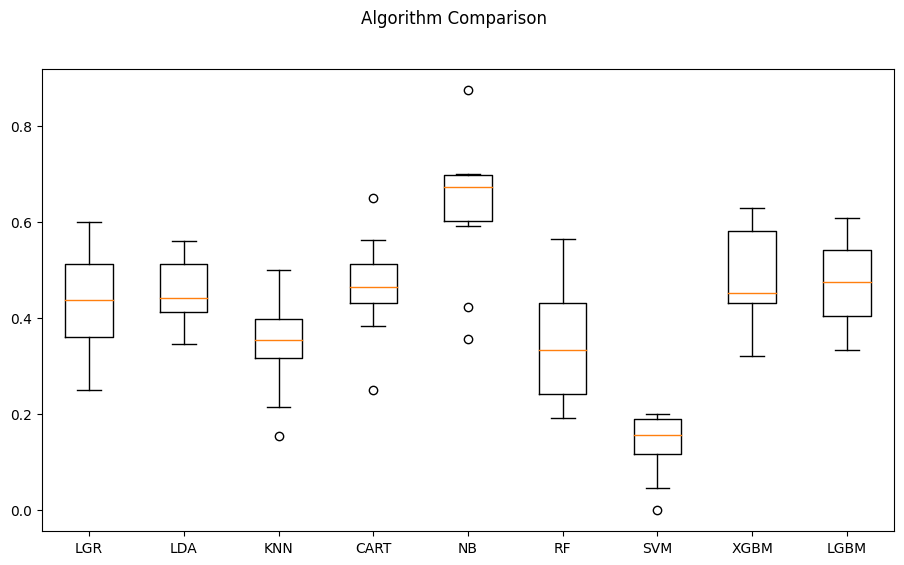

In [34]:
# evaluate each model in turn
results = []
names = []

for name, model in models:
        kfold = KFold(n_splits=10, random_state=7, shuffle = True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

My insights:

* Overall, the performance is suboptimal and requires further tuning is needed
* The Gaussian Naive Bayes classifier has produced the best results thus far. However, its tuning options are limited, which may constrain potential performance improvements.



## 5.2 Outlier removal using Z-score

In [35]:
def remove_outliers(X: pd.DataFrame, y: pd.DataFrame, numerical_columns: list, z_score_threshold: float):
    # Calculate Z-scores for numerical columns
    z_scores = X[numerical_columns].apply(zscore)

    # Identify outliers
    outliers = (np.abs(z_scores) > z_score_threshold).any(axis=1)

    # Number of outliers
    num_outliers = outliers.sum()
    print(f"Number of outliers: {num_outliers}")

    # Remove outliers
    X_clean = X[~outliers]
    y_clean = y[~outliers]

    return X_clean, y_clean

Z-score threshold is 3

In [36]:
X_with_one_Hot_encoding_clean, y_clean = remove_outliers(X_with_one_Hot_encoding, y, numerical_features, 3)

Number of outliers: 48


## 5.3 Minority class oversampling with smote

In [37]:
smote = SMOTE(random_state=42)

X_with_one_Hot_encoding, y_with_one_Hot_encoding_balanced =                smote.fit_resample(X_with_one_Hot_encoding_clean, y_clean)
small_X_with_one_Hot_encoding, y_small_with_one_Hot_encoding_balanced =    smote.fit_resample(small_X_with_one_Hot_encoding, y)
new_synthesized_X , y_new_synthesized =                                               smote.fit_resample(new_synthesized_X, y)

In [38]:
X_with_one_Hot_encoding

,duration,credit_amount,installment_rate,present_residence,age,number_of_existing_credits,dependents,checking_account_status_A12,checking_account_status_A13,checking_account_status_A14,...,property_A124,other_installment_plans_A142,other_installment_plans_A143,housing_A152,housing_A153,job_A172,job_A173,job_A174,telephone_A192,foreign_worker_A202
0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290,0.000000,0.0,0.0,...,0.000000,0.000000,1.0,1.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.0
1,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,1.000000,0.0,0.0,...,0.000000,0.000000,1.0,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.0
2,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869,0.000000,0.0,1.0,...,0.000000,0.000000,1.0,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.0
3,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869,0.000000,0.0,0.0,...,0.000000,0.000000,1.0,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.0
4,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869,0.000000,0.0,0.0,...,1.000000,0.000000,1.0,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,-0.038688,-0.708464,0.555275,0.508642,-1.032014,-0.704926,-0.428290,0.406117,0.0,0.0,...,0.000000,0.000000,1.0,0.406117,0.00000,0.406117,0.593883,0.000000,1.000000,0.0
1350,1.907386,-0.228081,0.918477,0.712286,-0.746229,-0.704926,-0.428290,0.000000,0.0,0.0,...,0.630770,0.000000,1.0,0.369230,0.63077,0.000000,1.000000,0.000000,0.630770,0.0
1351,1.795916,0.387024,0.918477,1.046987,1.934930,1.027079,-0.428290,0.454268,0.0,0.0,...,1.000000,0.545732,0.0,0.000000,1.00000,0.545732,0.454268,0.000000,0.454268,0.0
1352,-0.714472,-0.683780,-0.870183,-0.356794,-0.768741,-0.704926,-0.428290,1.000000,0.0,0.0,...,0.451397,0.000000,1.0,0.451397,0.00000,0.000000,1.000000,0.000000,0.000000,0.0


As we can see, it is necessary to re-binarize the columns affected by sampling that were originally one-hot-encoded, as they have lost their {0, 1} value set

In [39]:
def binarize_columns(df, columns):
    df_copy = df.copy()  # Make a copy of the DataFrame to avoid modifying the original one

    # Filter out columns that do not exist in the DataFrame
    valid_columns = [col for col in columns if col in df_copy.columns]

    # Binarize the specified valid columns
    df_copy[valid_columns] = df_copy[valid_columns].applymap(lambda x: 1.0 if x > 0.5 else 0.0)

    return df_copy

In [40]:
one_hot_encoded_columns = [pair for pair in encoded_to_cat_dict]

In [41]:
X_with_one_Hot_encoding = binarize_columns(X_with_one_Hot_encoding, one_hot_encoded_columns)
small_X_with_one_Hot_encoding = binarize_columns(small_X_with_one_Hot_encoding, one_hot_encoded_columns)

In [42]:
print(y_with_one_Hot_encoding_balanced['class'].value_counts())
print(y_small_with_one_Hot_encoding_balanced['class'].value_counts())
print(y_new_synthesized['class'].value_counts())

class
0    677
1    677
Name: count, dtype: int64
class
0    700
1    700
Name: count, dtype: int64
class
0    700
1    700
Name: count, dtype: int64


In [43]:
X_with_one_Hot_encoding

,duration,credit_amount,installment_rate,present_residence,age,number_of_existing_credits,dependents,checking_account_status_A12,checking_account_status_A13,checking_account_status_A14,...,property_A124,other_installment_plans_A142,other_installment_plans_A143,housing_A152,housing_A153,job_A172,job_A173,job_A174,telephone_A192,foreign_worker_A202
0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,-0.038688,-0.708464,0.555275,0.508642,-1.032014,-0.704926,-0.428290,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1350,1.907386,-0.228081,0.918477,0.712286,-0.746229,-0.704926,-0.428290,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1351,1.795916,0.387024,0.918477,1.046987,1.934930,1.027079,-0.428290,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1352,-0.714472,-0.683780,-0.870183,-0.356794,-0.768741,-0.704926,-0.428290,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_with_one_Hot_encoding, np.ravel(y_with_one_Hot_encoding_balanced), test_size = 0.25, random_state=42)

LGR: 0.777575 (0.065280)
LDA: 0.776082 (0.067673)
KNN: 0.860666 (0.048257)
CART: 0.812647 (0.071667)
NB: 0.927067 (0.037446)
RF: 0.879747 (0.047339)
SVM: 0.815842 (0.055671)
XGBM: 0.859061 (0.050371)
[LightGBM] [Info] Number of positive: 459, number of negative: 454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502738 -> initscore=0.010953
[LightGBM] [Info] Start training from score 0.010953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 471, number of negative: 442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You c

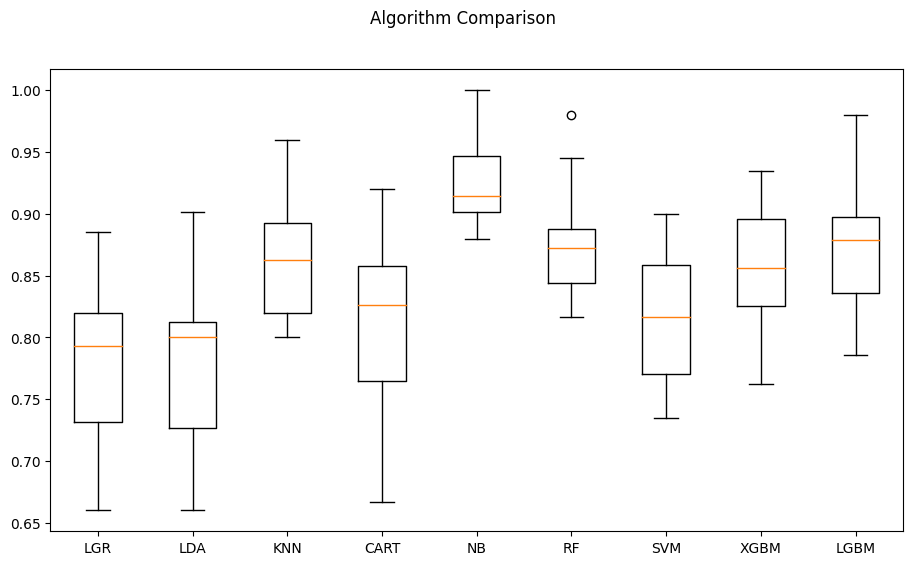

In [45]:
# evaluate each model in turn
results = []
names = []

for name, model in models:
        kfold = KFold(n_splits=10, random_state=7, shuffle = True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

My insights:

* Overall, the performance of all models improved noticeably
* KNN and The Gaussian Naive Bayes classifier yields the best results.
* Moving forward, I will continue tuning the both alongside the three required models for the task: (1) XGBoost, (2) Random Forest, and (3) LightGBM.


## 5.4 Tuning

In [46]:
def plot_grid_search_1d(model_name, param_values, mean_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, mean_scores, marker='o')
    plt.title(f'Grid Search Results for {model_name}')
    plt.xlabel('Number of Neighbors (K)')
    plt.ylabel('Mean Test Score')
    plt.grid(True)
    plt.show()

def plot_grid_search_3d(model_name, results):
    # Extracting grid search results
    mean_scores = results['mean_test_score']
    params = results['params']

    # Extracting hyperparameters
    param_names = list(params[0].keys())
    param_values = [[param[name] for param in params] for name in param_names]

    # Creating a DataFrame
    data = {name: values for name, values in zip(param_names, param_values)}
    data['Mean Score'] = mean_scores
    df = pd.DataFrame(data)

    # Creating the interactive 3D scatter plot
    fig = px.scatter_3d(df, x=param_names[0], y=param_names[1], z=param_names[2], color='Mean Score',
                         title=f'Grid Search for {model_name}',
                         labels={param_names[0]: param_names[0], param_names[1]: param_names[1], param_names[2]: param_names[2], 'Mean Score': 'Mean Score'},
                         color_continuous_scale='viridis')
    fig.show()

### 5.4.2 RandomForest

In [47]:
param_grid_RandomForest = {"max_depth": [3,5, 7, 10,None],
              "n_estimators":[3,5,10,25,50,150], ## is the number of trees to be used in the forest
              "max_features": [4,7,15,20]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search_RandomForest = GridSearchCV(model, param_grid=param_grid_RandomForest, cv=5, scoring= scoring , verbose=0)
grid_search_RandomForest.fit(X_train, y_train)

plot_grid_search_3d('RandomForest', grid_search_RandomForest.cv_results_)

In [48]:
print(grid_search_RandomForest.best_score_)
print(grid_search_RandomForest.best_params_)

0.8865384615384615
{'max_depth': 10, 'max_features': 15, 'n_estimators': 150}


### 5.4.2 XGB

In [49]:
param_grid_xgb = {
     'subsample': [0.5, 0.9, 1.0],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.3]
}

model_xgb = XGBClassifier(random_state=2)

grid_search_xgb = GridSearchCV(model_xgb, param_grid=param_grid_xgb, cv=5, scoring=scoring, verbose=0)
grid_search_xgb.fit(X_train, y_train)


plot_grid_search_3d('XGB', grid_search_xgb.cv_results_)

In [50]:
print(grid_search_xgb.best_score_)
print(grid_search_xgb.best_params_)

0.8692307692307691
{'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 1.0}


### 5.4.3 LightGBM

In [51]:
# Define the parameter grid for LightGBM
param_grid_lgbm = {
    'num_leaves': [31, 50, 70, 100],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.3]
}

# Initialize the LightGBM model
model_lgbm = LGBMClassifier(random_state=2)

# Setup the grid search
grid_search_lgbm = GridSearchCV(model_lgbm, param_grid=param_grid_lgbm, cv=5, scoring=scoring, verbose=0)

# Fit the grid search
grid_search_lgbm.fit(X_train, y_train)

plot_grid_search_3d('lgbm', grid_search_lgbm.cv_results_)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 416, number of negative: 396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 812, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512315 -> initscore=0.049271
[LightGBM] [Info] Start training from score 0.049271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [52]:
print(grid_search_lgbm.best_score_)
print(grid_search_lgbm.best_params_)

0.8596153846153847
{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}


### 5.4.4 KNN

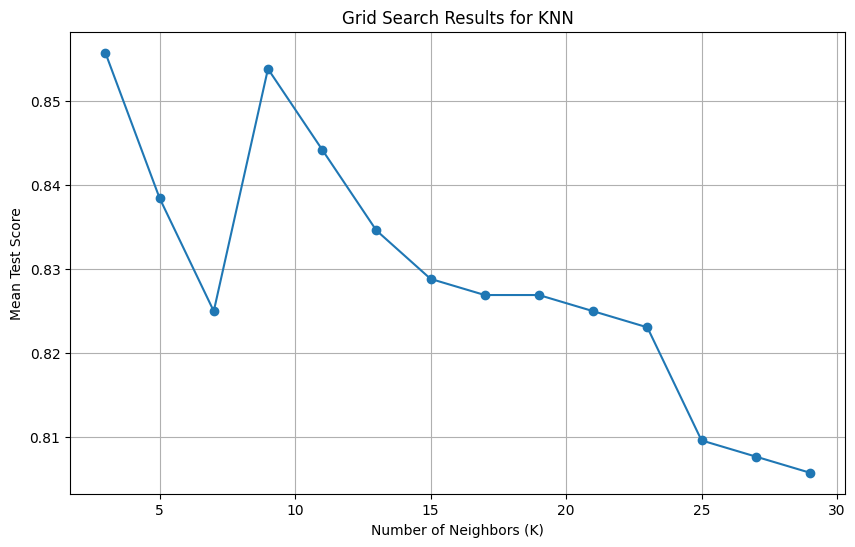

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for KNN (K only)
param_grid_knn = {
    'n_neighbors': range (3,31, 2 )# Add more values if needed
}

# Initialize the KNN model
model_knn = KNeighborsClassifier()

# Setup the grid search
grid_search_knn = GridSearchCV(model_knn, param_grid=param_grid_knn, cv=5, scoring=scoring, verbose=0)

# Fit the grid search
grid_search_knn.fit(X_train, y_train)

# Plot the grid search results for KNN
plot_grid_search_1d('KNN', param_grid_knn['n_neighbors'], grid_search_knn.cv_results_['mean_test_score'])

In [54]:
print(grid_search_knn.best_score_)
print(grid_search_knn.best_params_)

0.8557692307692306
{'n_neighbors': 3}


## 5.5 Testing on the main dataset

In [55]:
def train_and_plot(model, params, X_train, y_train, X_test, y_test, plotting=True, plot_feature_importances=False):
    # Record memory usage before training
    process = psutil.Process(os.getpid())

    # Start timer
    start_time = time()

    # Train the model
    if params is not None:
        model.set_params(**params)
    model.fit(X_train, y_train)


    p = pickle.dumps(model)
    model_size = sys.getsizeof(p)/ 1024

    # Calculate training time
    training_time = time() - start_time


    # Test the model on the test data
    y_pred = model.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate precision, recall, accuracy, and F1 score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate ROC curve
    y_scores = model.predict_proba(X_test)





    fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)

    # Print the report
    print("=== Report ===")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Model size: {model_size:.2f} KB")
    print(f"Traing time: {training_time:.2f} seconds")


    if plotting:
        # Plot confusion matrix with annotations
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
        plt.yticks([0, 1], ['Actual 0', 'Actual 1'])
        plt.xlabel('True label')
        plt.ylabel('Predicted label')
        plt.tight_layout()

        # Add annotations
        thresh = cm.max() / 2
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

        # Plot ROC curve
        plt.subplot(1, 3, 2)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.tight_layout()

        if plot_feature_importances and hasattr(model, 'feature_importances_'):
            # Plot feature importances
            importances = model.feature_importances_
            indices = np.argsort(importances)[-20:]  # top 20 features

            # Handle column names
            if hasattr(X_train, 'columns'):
                feature_names = X_train.columns
            else:
                feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]

            plt.subplot(1, 3, 3)
            plt.barh(range(len(indices)), importances[indices], align='center')
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.xlabel('Feature Importance')
            plt.title('Top 20 Feature Importances')
            plt.tight_layout()

        plt.show()

=== Report ===
Precision: 0.6604
Recall: 0.8917
Accuracy: 0.7375
F1 Score: 0.7588
Model size: 390.24 KB
Traing time: 0.01 seconds


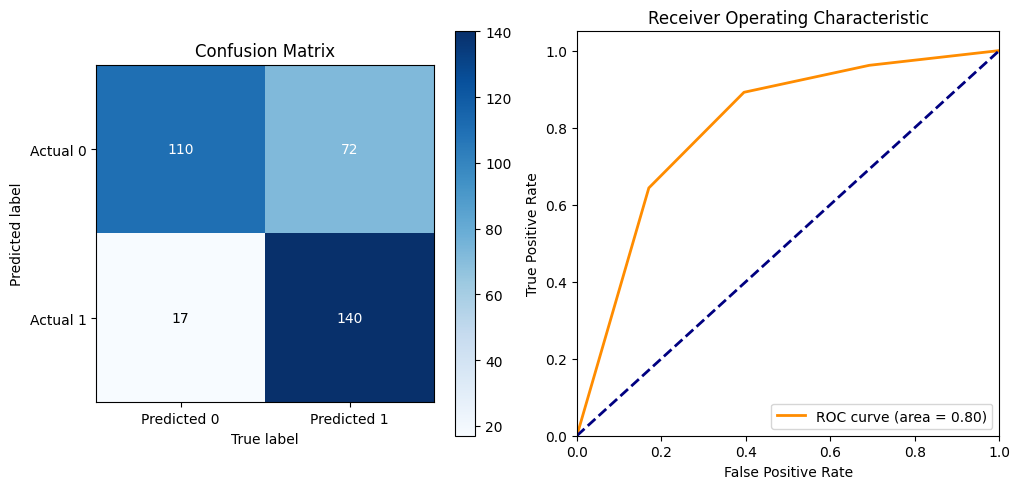

In [56]:
# Example usage for KNN
train_and_plot(KNeighborsClassifier(), grid_search_knn.best_params_, X_train, y_train, X_test, y_test)

=== Report ===
Precision: 0.5053
Recall: 0.9045
Accuracy: 0.5457
F1 Score: 0.6484
Model size: 3.10 KB
Traing time: 0.01 seconds


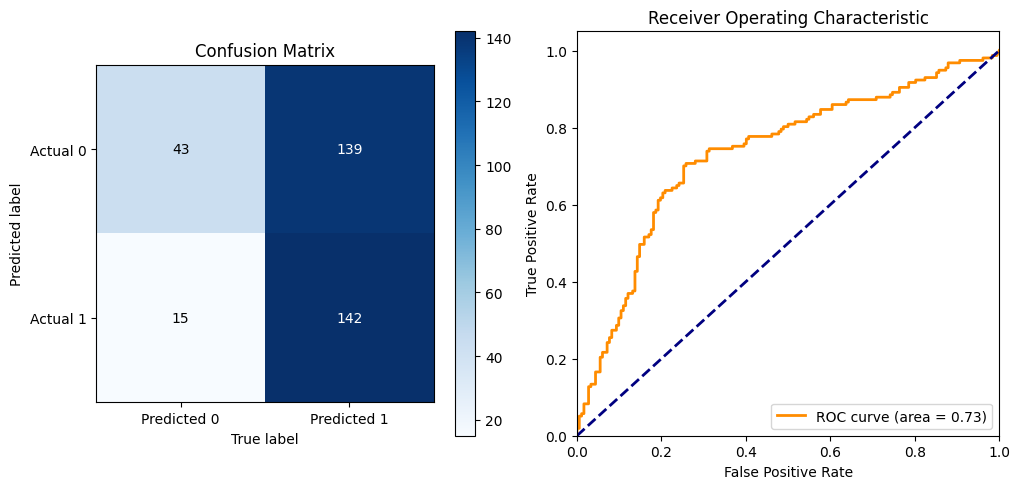

In [57]:
train_and_plot(GaussianNB(), None, X_train, y_train, X_test, y_test)

=== Report ===
Precision: 0.7688
Recall: 0.9108
Accuracy: 0.8319
F1 Score: 0.8338
Model size: 2357.98 KB
Traing time: 0.77 seconds


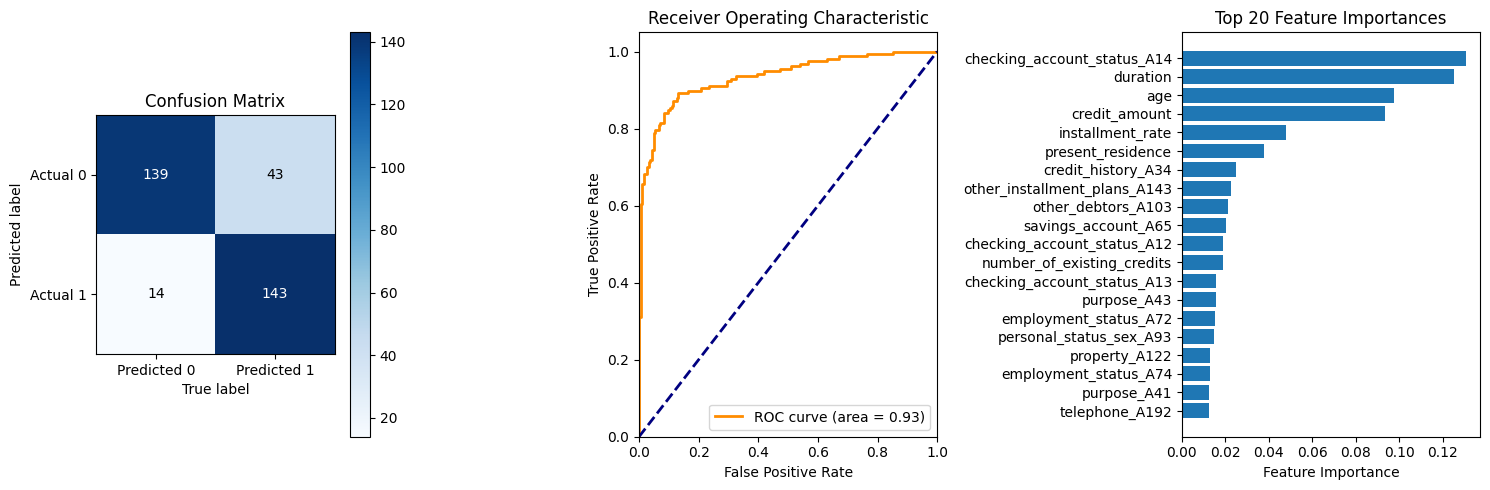

In [58]:
# Example usage for RandomForest
train_and_plot(RandomForestClassifier(), grid_search_RandomForest.best_params_, X_train, y_train, X_test, y_test, plot_feature_importances = True)

=== Report ===
Precision: 0.8107
Recall: 0.8726
Accuracy: 0.8466
F1 Score: 0.8405
Model size: 483.62 KB
Traing time: 0.28 seconds


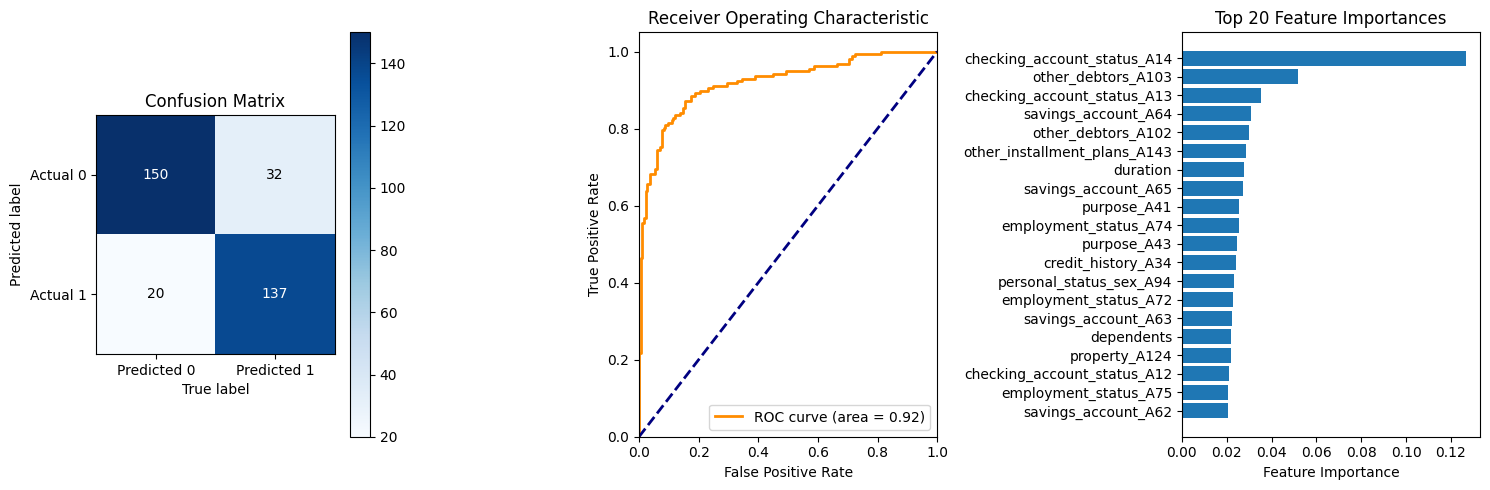

In [59]:
train_and_plot(XGBClassifier(), grid_search_xgb.best_params_, X_train, y_train, X_test, y_test, plot_feature_importances = True)

[LightGBM] [Info] Number of positive: 520, number of negative: 495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 1015, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512315 -> initscore=0.049271
[LightGBM] [Info] Start training from score 0.049271
=== Report ===
Precision: 0.8354
Recall: 0.8726
Accuracy: 0.8614
F1 Score: 0.8536
Model size: 341.42 KB
Traing time: 0.10 seconds


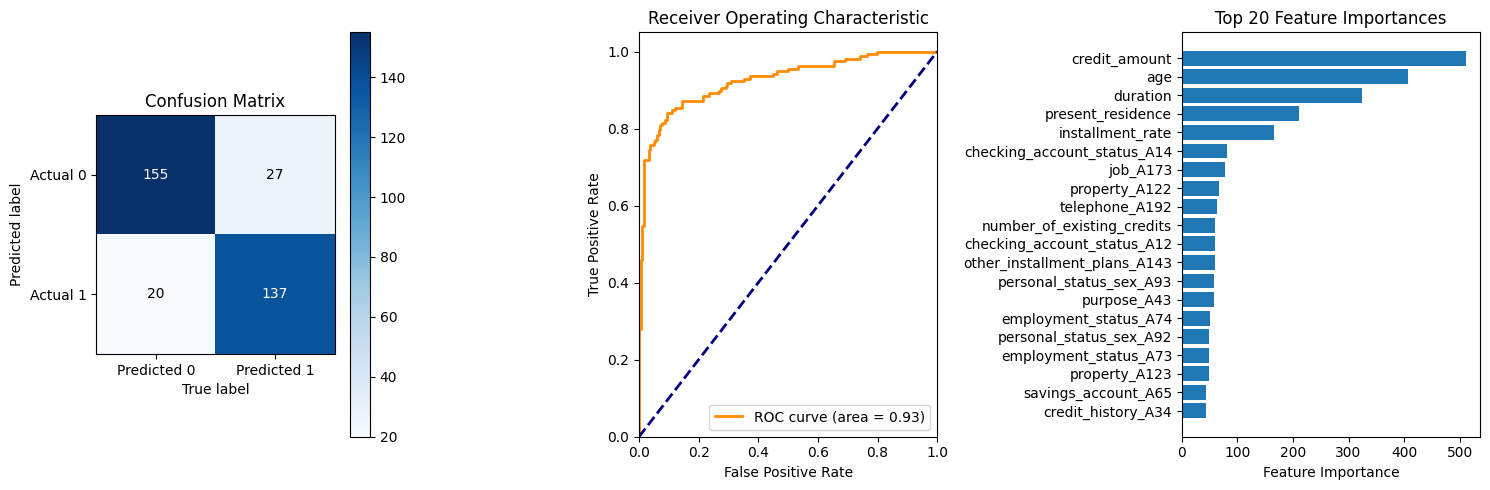

In [60]:
train_and_plot(LGBMClassifier(), grid_search_lgbm.best_params_, X_train, y_train, X_test, y_test, plot_feature_importances = True)

My insights on memory and train time:
* Training Gaussian naive bayes takes the least time and the smallest memory, This is because it only needs to calculate the mean and variance of each feature for each class, and store these values.

* The size of the trained KNN model in memory is relatively high is relatively high since it requires storing the entire dataset.

## 5.6 Trying the other alternative feature sets

### 5.6.1 Using the selected subset of the original feature set

In [61]:
X_train, X_test, y_train, y_test = train_test_split(small_X_with_one_Hot_encoding, np.ravel(y_small_with_one_Hot_encoding_balanced), test_size = 0.25, random_state=42)
train_and_plot(GaussianNB(), None, X_train, y_train, X_test, y_test, False)

=== Report ===
Precision: 0.6425
Recall: 0.8503
Accuracy: 0.7029
F1 Score: 0.7320
Model size: 2.34 KB
Traing time: 0.01 seconds


In [62]:
X_train, X_test, y_train, y_test = train_test_split(small_X_with_one_Hot_encoding, np.ravel(y_small_with_one_Hot_encoding_balanced), test_size = 0.25, random_state=42)
train_and_plot(RandomForestClassifier(), grid_search_RandomForest.best_params_, X_train, y_train, X_test, y_test, False)

=== Report ===
Precision: 0.7400
Recall: 0.8862
Accuracy: 0.7971
F1 Score: 0.8065
Model size: 2361.91 KB
Traing time: 0.41 seconds


In [63]:
X_train, X_test, y_train, y_test = train_test_split(small_X_with_one_Hot_encoding, np.ravel(y_small_with_one_Hot_encoding_balanced), test_size = 0.25, random_state=42)
train_and_plot(XGBClassifier(), grid_search_xgb.best_params_, X_train, y_train, X_test, y_test, False)

=== Report ===
Precision: 0.7360
Recall: 0.7844
Accuracy: 0.7629
F1 Score: 0.7594
Model size: 417.26 KB
Traing time: 0.29 seconds


In [64]:
X_train, X_test, y_train, y_test = train_test_split(small_X_with_one_Hot_encoding, np.ravel(y_small_with_one_Hot_encoding_balanced), test_size = 0.25, random_state=42)
train_and_plot(LGBMClassifier(), grid_search_lgbm.best_params_, X_train, y_train, X_test, y_test, False)

[LightGBM] [Info] Number of positive: 533, number of negative: 517
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 1050, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507619 -> initscore=0.030479
[LightGBM] [Info] Start training from score 0.030479
=== Report ===
Precision: 0.7514
Recall: 0.7784
Accuracy: 0.7714
F1 Score: 0.7647
Model size: 343.51 KB
Traing time: 0.09 seconds


My insights:
* THAT ACTUALLY NOT BAD !!!! :D
* Nice feature selection me :DDDD

### 5.6.2 Using the new synthesized features that

In [65]:
X_train, X_test, y_train, y_test = train_test_split(new_synthesized_X, np.ravel(y_new_synthesized), test_size = 0.25, random_state=42)
train_and_plot(GaussianNB(), None, X_train, y_train, X_test, y_test, False)

=== Report ===
Precision: 0.6649
Recall: 0.7365
Accuracy: 0.6971
F1 Score: 0.6989
Model size: 0.91 KB
Traing time: 0.01 seconds


In [66]:
X_train, X_test, y_train, y_test = train_test_split(new_synthesized_X, np.ravel(y_new_synthesized), test_size = 0.25, random_state=42)
train_and_plot(RandomForestClassifier(), grid_search_RandomForest.best_params_, X_train, y_train, X_test, y_test, False)

=== Report ===
Precision: 0.7653
Recall: 0.8982
Accuracy: 0.8200
F1 Score: 0.8264
Model size: 1893.82 KB
Traing time: 1.75 seconds


In [67]:
X_train, X_test, y_train, y_test = train_test_split(new_synthesized_X, np.ravel(y_new_synthesized), test_size = 0.25, random_state=42)
train_and_plot(XGBClassifier(), grid_search_xgb.best_params_, X_train, y_train, X_test, y_test, False)

=== Report ===
Precision: 0.7831
Recall: 0.8862
Accuracy: 0.8286
F1 Score: 0.8315
Model size: 459.42 KB
Traing time: 1.08 seconds


In [68]:
X_train, X_test, y_train, y_test = train_test_split(new_synthesized_X, np.ravel(y_new_synthesized), test_size = 0.25, random_state=42)
train_and_plot(LGBMClassifier(), grid_search_lgbm.best_params_, X_train, y_train, X_test, y_test, False)

[LightGBM] [Info] Number of positive: 533, number of negative: 517
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1050, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507619 -> initscore=0.030479
[LightGBM] [Info] Start training from score 0.030479
=== Report ===
Precision: 0.7819
Recall: 0.8802
Accuracy: 0.8257
F1 Score: 0.8282
Model size: 333.98 KB
Traing time: 0.14 seconds


My insights:
* The models achieved [unexpectedly] good performance using just the top 10 principal components, which account for 36% of the total variance

* Further investigation is needed to determine if this outcome is typical or if there are other factors at play.